# Satellite Image Processing with Deep Learning

In this notebook you will:
- Solve the EuroSAT-10 classification problem,
- to that end use Convolutional Neural Networks,
- decrease overfitting with dropout,
- decrease overfitting even further with data augmentation, and
- solve the problem with transfer learning.

First two cells provides with imports and data downloads.

## Import all necessary modules  and check TensorFlow version.

In [1]:
import tensorflow as tf
assert tf.__version__.startswith("2."), "You have TensorFlow version {}, 2.X is required, please upgrade.".format(tf.__version__)

import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

## Load and split EuroSAT-dataset.

We split the data into three subsets:
- Train: For training the Neural Network.
- Validate: To see how good the Neural Network is after each epoch.
- Test: To see how good the Neural Network is after training.

In [2]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    name="eurosat/rgb", 
    split=["train[:70%]", "train[70%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)
print(info)
print("Train:   ", len(list(dataset_train_original)))
print("Validate:", len(list(dataset_validate_original)))
print("Test:    ", len(list(dataset_test_original)))

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

In [3]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea & lake"]

def label_to_string(label):
  return class_names[label]

## Exploratory Data Analysis

In [4]:
len(list(dataset_train_original)), len(list(dataset_validate_original)), len(list(dataset_test_original))

(18900, 5400, 2700)

### The train dataset has 18900 samples, validation has 5400 and test set has 2700 samples. Convert them to numpy arrays

In [5]:
train_array = np.vstack(tfds.as_numpy(dataset_train_original))

X_train = np.array(list(map(lambda x: x[0], train_array)))
y_train = np.array(list(map(lambda x: x[1], train_array)))

/home/watts/anaconda3/envs/cgm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [6]:
train_array.shape

(18900, 2)

In [7]:
X_train.shape, y_train.shape

((18900, 64, 64, 3), (18900,))

In [8]:
valid_array = np.vstack(tfds.as_numpy(dataset_validate_original))

X_valid = np.array(list(map(lambda x: x[0], valid_array)))
y_valid = np.array(list(map(lambda x: x[1], valid_array)))

/home/watts/anaconda3/envs/cgm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [9]:
valid_array.shape, X_valid.shape, y_valid.shape

((5400, 2), (5400, 64, 64, 3), (5400,))

In [10]:
test_array = np.vstack(tfds.as_numpy(dataset_test_original))

X_test = np.array(list(map(lambda x: x[0], test_array)))
y_test = np.array(list(map(lambda x: x[1], test_array)))

/home/watts/anaconda3/envs/cgm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [11]:
test_array.shape, X_test.shape, y_test.shape

((2700, 2), (2700, 64, 64, 3), (2700,))

### The shape of each RGB image is 64x64x3

In [12]:
len(y_train[y_train==0])

2123

### Plot class distributions for the train dataset

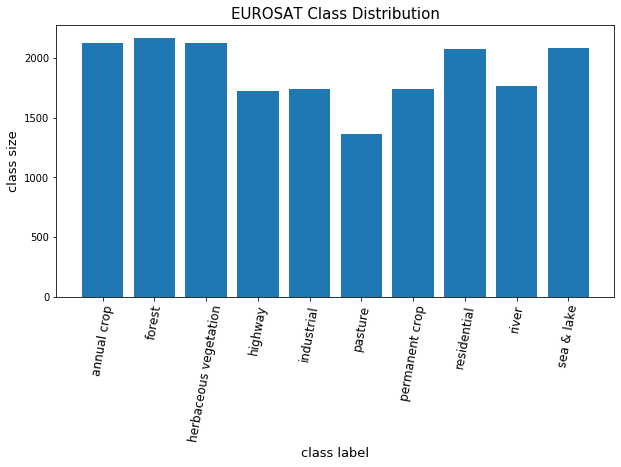

In [13]:
# plot class distributions of train dataset
train_counts = {}

for i, l in enumerate(class_names):
    train_counts[l] = len(y_train[y_train==i])

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(train_counts)), list(train_counts.values()), align='center')
plt.xticks(range(len(train_counts)), list(train_counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

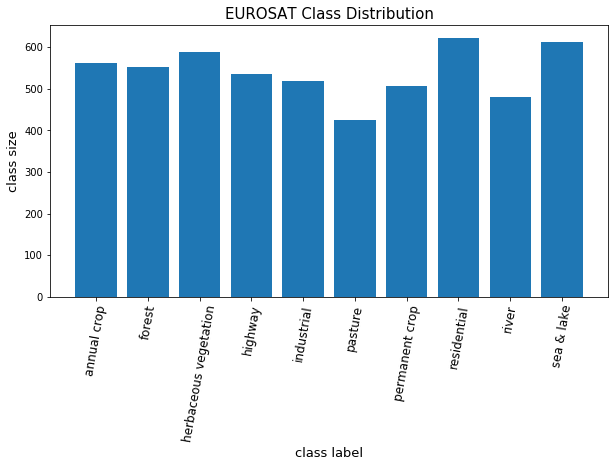

In [14]:
# plot class distributions of valid dataset
valid_counts = {}

for i, l in enumerate(class_names):
    valid_counts[l] = len(y_valid[y_valid==i])

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(valid_counts)), list(valid_counts.values()), align='center')
plt.xticks(range(len(valid_counts)), list(valid_counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

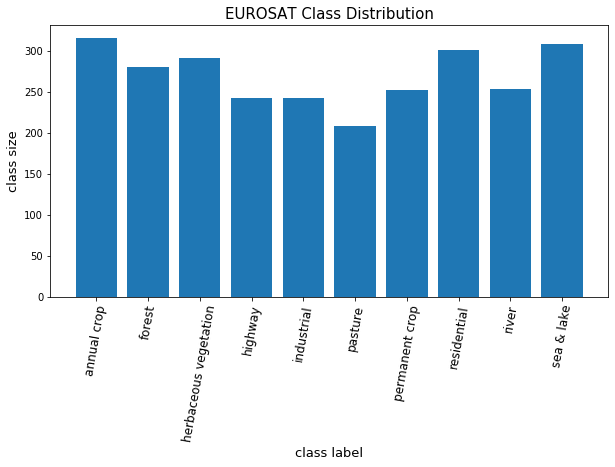

In [32]:
# plot class distributions of test dataset
from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))


test_counts = {}

for i, l in enumerate(class_names):
    test_counts[l] = len(y_test[y_test==i])

    
plt.figure(figsize=(10, 5))

# fig, ax = plt.subplots()

plt.bar(range(len(test_counts)), list(test_counts.values()), align='center')
plt.xticks(range(len(test_counts)), list(test_counts.keys()), fontsize=12, rotation=80)
# ax.yaxis.set_major_formatter(formatter)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

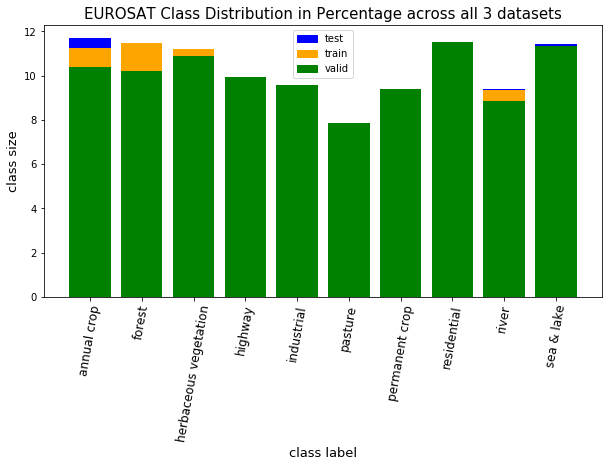

In [41]:
# lets calculate distribution in percentages
train_pct = {}
valid_pct = {}
test_pct = {}

for i, l in enumerate(class_names):
    valid_pct[l] = len(y_valid[y_valid==i])/len(y_valid) * 100
    train_pct[l] = len(y_train[y_train==i])/len(y_train) * 100
    test_pct[l] = len(y_test[y_test==i])/len(y_test) * 100

    
plt.figure(figsize=(10, 5))

colors = {'test':'blue', 'train':'orange', 'valid':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(range(len(test_pct)), list(test_pct.values()), align='center', color='blue')
plt.bar(range(len(train_pct)), list(train_pct.values()), align='center', color='orange')
plt.bar(range(len(valid_pct)), list(valid_pct.values()), align='center', color='green')
plt.xticks(range(len(test_pct)), list(test_pct.keys()), fontsize=12, rotation=80)

plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution in Percentage across all 3 datasets', fontsize=15);

In [38]:
train_pct, valid_pct, test_pct

({'annual crop': 11.232804232804233,
  'forest': 11.465608465608465,
  'herbaceous vegetation': 11.222222222222221,
  'highway': 9.105820105820106,
  'industrial': 9.201058201058201,
  'pasture': 7.227513227513227,
  'permanent crop': 9.206349206349207,
  'residential': 10.989417989417989,
  'river': 9.349206349206348,
  'sea & lake': 11.0},
 {'annual crop': 10.38888888888889,
  'forest': 10.222222222222223,
  'herbaceous vegetation': 10.888888888888888,
  'highway': 9.925925925925926,
  'industrial': 9.592592592592593,
  'pasture': 7.87037037037037,
  'permanent crop': 9.388888888888888,
  'residential': 11.518518518518519,
  'river': 8.87037037037037,
  'sea & lake': 11.333333333333332},
 {'annual crop': 11.703703703703704,
  'forest': 10.407407407407407,
  'herbaceous vegetation': 10.777777777777779,
  'highway': 9.0,
  'industrial': 9.0,
  'pasture': 7.740740740740741,
  'permanent crop': 9.37037037037037,
  'residential': 11.148148148148149,
  'river': 9.407407407407407,
  'sea & 

### The distribution of classes across train, valid and test sets is more or less similar

We see that for 'annual crop' and 'sea and lake', the test set has slightly higher percentage than others
For 'annual crop', 'forest', 'herbaceous vegetation' and 'river' classes, train set has slightly higher percentage

### Lets visualize some images

In [65]:
y_train_list = {}
imgs = []
labels = []
for i, c in enumerate(class_names): 
    y_train_list[c] = list(filter(lambda x: y_train[x] == i, range(len(y_train)))) 
    imgs.append(X_train[y_train_list[c][0]])
    labels.append(c)
    
for i, c in enumerate(class_names): 
    imgs.append(X_train[y_train_list[c][10]])
    labels.append(c)    

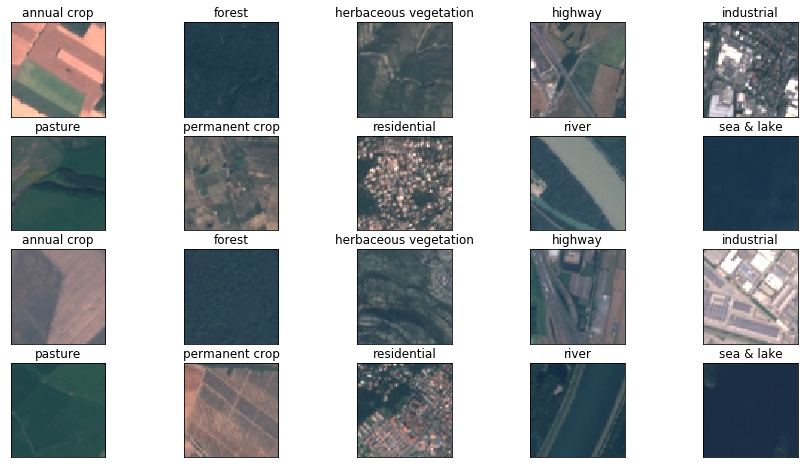

In [67]:
def plot_sat_imgs(imgs, labels):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        plt.imshow(imgs[i])
        plt.title(labels[i])

plot_sat_imgs(imgs, labels)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes.

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways.

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances.

The satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.

## Create a Deep Neural Network to solve our classification problem - Convolutional Neural Network.


In [13]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score

BATCH_SIZE = 64
NUM_CLASSES=len(class_names)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'


Using TensorFlow backend.


In [14]:
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)
# y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [15]:
y_train.shape

(18900, 10)

In [16]:
# X_train = np.moveaxis(X_train, -1, 1)
# X_valid = np.moveaxis(X_valid, -1, 1)

In [17]:
X_train.shape

(18900, 64, 64, 3)

In [18]:
# training generator - create one for validation subset
# Augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

valid_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(
    rescale=1./255,
)

train_gen.fit(X_train, augment=True)
valid_gen.fit(X_valid, augment=True)
test_gen.fit(X_test)

train_generator = train_gen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_generator = valid_gen.flow(
    X_valid,
    y_valid,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = test_gen.flow(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [19]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)
    
# tf.config.set_soft_device_placement(True)

In [20]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels) 
    f1 = fbeta_score(y_true, y_preds, beta=1, average='micro')
    print(f"Global F1 Score: {f1}")   
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_arr, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(len(test_arr), size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_arr[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))   

In [21]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [22]:
def get_model(input_shape, n_classes):
#     model = keras.Sequential([
    inp = L.Input(shape=input_shape)
    x = L.BatchNormalization()(inp)
    x = L.Conv2D(filters=16, kernel_size=5, padding='same', activation='elu', data_format='channels_last')(x)
    x = L.MaxPool2D(data_format='channels_last')(x)
    
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, 3, padding='same', activation='elu')(x)
    x = L.Conv2D(32, 3, padding='same', activation='elu')(x)
    x = L.MaxPool2D()(x)
    
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, 3, padding='same', activation='elu') (x)
    x = L.Conv2D(64, 3, padding='same', activation='elu') (x)
    x = L.MaxPool2D()(x)
    
    x = L.Flatten()(x)
    x = L.Dense(128, activation='elu') (x)
    x = L.Dropout(0.5) (x)
    x = L.Dense(64, activation='elu') (x)
    x = L.Dropout(0.5) (x)
    x = L.Dense(n_classes, activation='softmax') (x)
#     ])
    model = Model(inp, x)
   
    return model

In [23]:
model = get_model(INPUT_SHAPE, NUM_CLASSES)
adam = Adam(lr = 3e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)       

In [64]:
from tensorflow.keras.callbacks import LearningRateScheduler
N_STEPS = len(X_train)//BATCH_SIZE
N_VAL_STEPS = len(X_valid)//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='../cache/model_weights_best.hdf5',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min')

decay_steps = 25
initial_learning_rate = 3e-4
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate, decay_steps)
lr_sched = LearningRateScheduler(lr_decayed_fn)

In [25]:
X_train.shape

(18900, 64, 64, 3)

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[lr_sched, early_stop, checkpoint],
    validation_data=valid_generator,
    validation_steps=N_VAL_STEPS)



Epoch 1/100
295/295 [==============================] - ETA: 0s - loss: 1.6151 - categorical_accuracy: 0.4538
Epoch 00001: val_categorical_accuracy improved from -inf to 0.35472, saving model to ../cache/model_weights_best.hdf5
295/295 [==============================] - 39s 133ms/step - loss: 1.6151 - categorical_accuracy: 0.4538 - val_loss: 1.8028 - val_categorical_accuracy: 0.3547
Epoch 2/100
295/295 [==============================] - ETA: 0s - loss: 1.2640 - categorical_accuracy: 0.5650
Epoch 00002: val_categorical_accuracy improved from 0.35472 to 0.66183, saving model to ../cache/model_weights_best.hdf5
295/295 [==============================] - 39s 133ms/step - loss: 1.2640 - categorical_accuracy: 0.5650 - val_loss: 0.9521 - val_categorical_accuracy: 0.6618
Epoch 3/100
295/295 [==============================] - ETA: 0s - loss: 1.1298 - categorical_accuracy: 0.6118
Epoch 00003: val_categorical_accuracy improved from 0.66183 to 0.71577, saving model to ../cache/model_weights_best.hd

Epoch 24/100
295/295 [==============================] - ETA: 0s - loss: 0.5059 - categorical_accuracy: 0.8363
Epoch 00024: val_categorical_accuracy did not improve from 0.87054
295/295 [==============================] - 41s 138ms/step - loss: 0.5059 - categorical_accuracy: 0.8363 - val_loss: 0.4052 - val_categorical_accuracy: 0.8657
Epoch 25/100
295/295 [==============================] - ETA: 0s - loss: 0.5168 - categorical_accuracy: 0.8348
Epoch 00025: val_categorical_accuracy did not improve from 0.87054
295/295 [==============================] - 41s 138ms/step - loss: 0.5168 - categorical_accuracy: 0.8348 - val_loss: 0.4145 - val_categorical_accuracy: 0.8586
Epoch 26/100
295/295 [==============================] - ETA: 0s - loss: 0.5083 - categorical_accuracy: 0.8382
Epoch 00026: val_categorical_accuracy did not improve from 0.87054
295/295 [==============================] - 41s 138ms/step - loss: 0.5083 - categorical_accuracy: 0.8382 - val_loss: 0.6853 - val_categorical_accuracy: 0.

295/295 [==============================] - ETA: 0s - loss: 0.3675 - categorical_accuracy: 0.8856
Epoch 00047: val_categorical_accuracy did not improve from 0.91109
295/295 [==============================] - 40s 137ms/step - loss: 0.3675 - categorical_accuracy: 0.8856 - val_loss: 0.2641 - val_categorical_accuracy: 0.9062
Epoch 48/100
295/295 [==============================] - ETA: 0s - loss: 0.3752 - categorical_accuracy: 0.8834
Epoch 00048: val_categorical_accuracy did not improve from 0.91109
295/295 [==============================] - 41s 139ms/step - loss: 0.3752 - categorical_accuracy: 0.8834 - val_loss: 0.2880 - val_categorical_accuracy: 0.9009
Epoch 49/100
295/295 [==============================] - ETA: 0s - loss: 0.3838 - categorical_accuracy: 0.8822
Epoch 00049: val_categorical_accuracy did not improve from 0.91109
295/295 [==============================] - 40s 137ms/step - loss: 0.3838 - categorical_accuracy: 0.8822 - val_loss: 0.3025 - val_categorical_accuracy: 0.8956
Epoch 50

Epoch 71/100
295/295 [==============================] - ETA: 0s - loss: 0.2950 - categorical_accuracy: 0.9053
Epoch 00071: val_categorical_accuracy improved from 0.92690 to 0.92820, saving model to ../cache/model_weights_best.hdf5
295/295 [==============================] - 41s 139ms/step - loss: 0.2950 - categorical_accuracy: 0.9053 - val_loss: 0.2262 - val_categorical_accuracy: 0.9282
Epoch 72/100
295/295 [==============================] - ETA: 0s - loss: 0.3029 - categorical_accuracy: 0.9065
Epoch 00072: val_categorical_accuracy improved from 0.92820 to 0.93006, saving model to ../cache/model_weights_best.hdf5
295/295 [==============================] - 42s 142ms/step - loss: 0.3029 - categorical_accuracy: 0.9065 - val_loss: 0.2150 - val_categorical_accuracy: 0.9301


### Accuracy plots

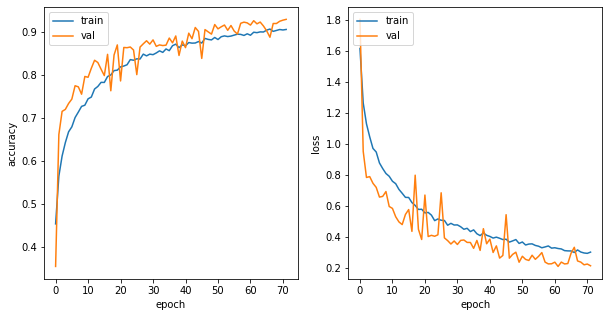

In [27]:
plot_history(history)

In [40]:
model.load_weights('../cache/model_weights_best.hdf5')

test_generator.reset()

predictions = model.predict(test_generator)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = y_test

In [71]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true_classes, predicted_classes))

0.9066666666666666


In [41]:
predicted_classes.shape

(2700,)

In [42]:
true_classes.shape

(2700,)

In [43]:
prf, conf_mat = display_results(true_classes, predicted_classes, class_names)

Global F1 Score: 0.9066666666666666
Global F2 Score: 0.9066666666666667


In [44]:
prf

,Precision,Recall,F-Score,Support
annual crop,0.872671,0.889241,0.880878,316.0
forest,0.915309,1.000000,0.955782,281.0
herbaceous vegetation,0.921933,0.852234,0.885714,291.0
highway,0.979899,0.802469,0.882353,243.0
industrial,0.914414,0.835391,0.873118,243.0
pasture,0.924623,0.880383,0.901961,209.0
permanent crop,0.891051,0.905138,0.898039,253.0
residential,0.794195,1.000000,0.885294,301.0
river,0.922481,0.937008,0.929688,254.0
sea & lake,1.000000,0.932039,0.964824,309.0


In [46]:
conf_mat

,annual crop,forest,herbaceous vegetation,highway,industrial,pasture,permanent crop,residential,river,sea & lake
annual crop,281,3,3,2,0,4,15,0,8,0
forest,0,281,0,0,0,0,0,0,0,0
herbaceous vegetation,9,2,248,0,3,2,6,20,1,0
highway,11,0,1,195,15,3,2,13,3,0
industrial,1,0,0,0,203,0,0,38,1,0
pasture,3,12,6,0,0,184,3,0,1,0
permanent crop,9,0,9,0,1,0,229,5,0,0
residential,0,0,0,0,0,0,0,301,0,0
river,3,0,2,2,0,5,2,2,238,0
sea & lake,5,9,0,0,0,1,0,0,6,288


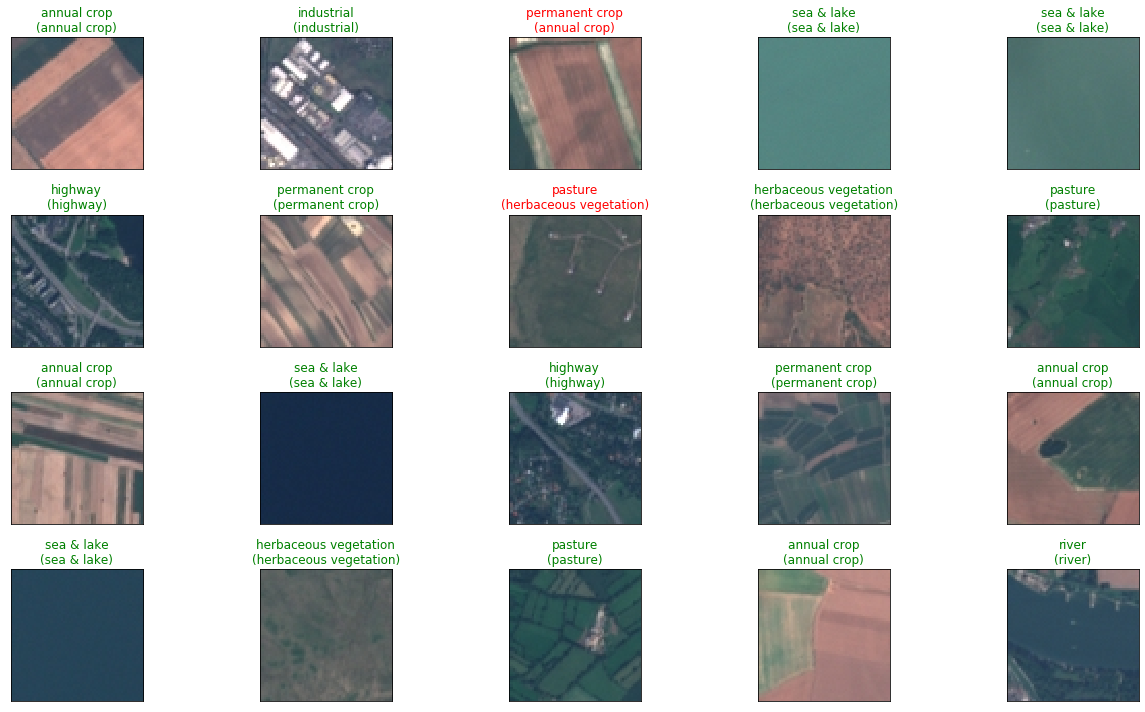

In [55]:
plot_predictions(true_classes, predictions, X_test, class_names)

### Lets take a deeper CNN for experimentation (resnet based)

In [75]:
def get_model2(shape=(64, 64, 3)):
    def res_block(x, n_features):
        _x = x
        x = L.BatchNormalization()(x)
        x = L.LeakyReLU(0.05)(x)
    
        x = L.Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = L.Add()([_x, x])
        return x
    
    inp = L.Input(shape=shape)
    
     # 128
    x = L.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
    for _ in range(2):
        x = res_block(x, 16)
    x = L.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = L.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = L.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = L.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = L.AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = L.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = L.GlobalAveragePooling2D()(x)
    
    
    x = L.Dense(128, activation='elu') (x)
    x = L.Dropout(0.5) (x)
    x = L.Dense(64, activation='elu') (x)
    x = L.Dropout(0.5) (x)
    x = L.Dense(NUM_CLASSES, activation='softmax') (x)
    
    return Model(inp , x)

In [76]:
model = get_model2()

In [77]:
adam = Adam(lr = 3e-4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [78]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 64, 64, 16)   64          conv2d_46[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_30 (LeakyReLU)      (None, 64, 64, 16)   0           batch_normalization_33[0][0]     
_______________________________________________________________________________________

In [79]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='../cache/model_weights_best2.hdf5',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    verbose=1)

In [80]:
history = model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[lr_sched, early_stop, checkpoint2],
    validation_data=valid_generator,
    validation_steps=N_VAL_STEPS)

Epoch 1/100
295/295 [==============================] - ETA: 0s - loss: 1.6877 - categorical_accuracy: 0.4583
Epoch 00001: val_categorical_accuracy improved from -inf to 0.26135, saving model to ../cache/model_weights_best2.hdf5
295/295 [==============================] - 40s 135ms/step - loss: 1.6877 - categorical_accuracy: 0.4583 - val_loss: 2.2537 - val_categorical_accuracy: 0.2613
Epoch 2/100
295/295 [==============================] - ETA: 0s - loss: 1.2273 - categorical_accuracy: 0.5980
Epoch 00002: val_categorical_accuracy improved from 0.26135 to 0.51804, saving model to ../cache/model_weights_best2.hdf5
295/295 [==============================] - 39s 134ms/step - loss: 1.2273 - categorical_accuracy: 0.5980 - val_loss: 1.5871 - val_categorical_accuracy: 0.5180
Epoch 3/100
295/295 [==============================] - ETA: 0s - loss: 1.0632 - categorical_accuracy: 0.6536
Epoch 00003: val_categorical_accuracy improved from 0.51804 to 0.66648, saving model to ../cache/model_weights_best2

295/295 [==============================] - ETA: 0s - loss: 0.3242 - categorical_accuracy: 0.8998
Epoch 00023: val_categorical_accuracy improved from 0.91555 to 0.91611, saving model to ../cache/model_weights_best2.hdf5
295/295 [==============================] - 43s 144ms/step - loss: 0.3242 - categorical_accuracy: 0.8998 - val_loss: 0.2555 - val_categorical_accuracy: 0.9161
Epoch 24/100
295/295 [==============================] - ETA: 0s - loss: 0.3236 - categorical_accuracy: 0.9019
Epoch 00024: val_categorical_accuracy improved from 0.91611 to 0.92262, saving model to ../cache/model_weights_best2.hdf5
295/295 [==============================] - 43s 147ms/step - loss: 0.3236 - categorical_accuracy: 0.9019 - val_loss: 0.2361 - val_categorical_accuracy: 0.9226
Epoch 25/100
295/295 [==============================] - ETA: 0s - loss: 0.3190 - categorical_accuracy: 0.9023
Epoch 00025: val_categorical_accuracy did not improve from 0.92262
295/295 [==============================] - 42s 144ms/ste

Epoch 47/100
295/295 [==============================] - ETA: 0s - loss: 0.3133 - categorical_accuracy: 0.9039
Epoch 00047: val_categorical_accuracy did not improve from 0.92541
295/295 [==============================] - 43s 145ms/step - loss: 0.3133 - categorical_accuracy: 0.9039 - val_loss: 0.2373 - val_categorical_accuracy: 0.9222
Epoch 48/100
295/295 [==============================] - ETA: 0s - loss: 0.3196 - categorical_accuracy: 0.9023
Epoch 00048: val_categorical_accuracy did not improve from 0.92541
295/295 [==============================] - 43s 146ms/step - loss: 0.3196 - categorical_accuracy: 0.9023 - val_loss: 0.2428 - val_categorical_accuracy: 0.9206
Epoch 49/100
295/295 [==============================] - ETA: 0s - loss: 0.3122 - categorical_accuracy: 0.9050
Epoch 00049: val_categorical_accuracy did not improve from 0.92541
295/295 [==============================] - 43s 147ms/step - loss: 0.3122 - categorical_accuracy: 0.9050 - val_loss: 0.2363 - val_categorical_accuracy: 0.

### The deeper resent based CNN converged faster but with slightly less val accuracy

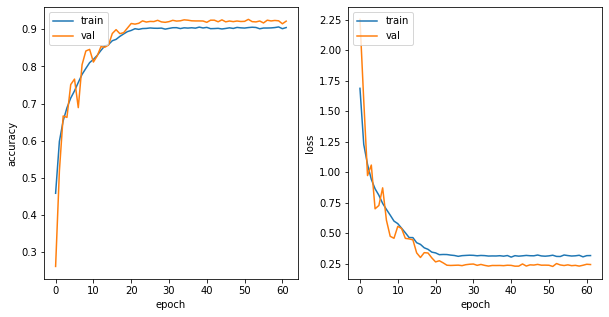

In [81]:
plot_history(history)

In [82]:
model.load_weights('../cache/model_weights_best2.hdf5')

test_generator.reset()

predictions = model.predict(test_generator)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = y_test

In [83]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true_classes, predicted_classes))

0.9103703703703704


### This is better on the accuracy and F1, F2 scores of the earlier model. So this model generalizes better.

In [84]:
prf, conf_mat = display_results(true_classes, predicted_classes, class_names)

Global F1 Score: 0.9103703703703704
Global F2 Score: 0.9103703703703705


In [85]:
prf

,Precision,Recall,F-Score,Support
annual crop,0.863777,0.882911,0.873239,316.0
forest,0.936667,1.000000,0.967298,281.0
herbaceous vegetation,0.932075,0.848797,0.888489,291.0
highway,0.950980,0.798354,0.868009,243.0
industrial,0.889344,0.893004,0.891170,243.0
pasture,0.900943,0.913876,0.907363,209.0
permanent crop,0.871094,0.881423,0.876228,253.0
residential,0.847458,0.996678,0.916031,301.0
river,0.942857,0.909449,0.925852,254.0
sea & lake,0.993266,0.954693,0.973597,309.0


In [86]:
conf_mat

,annual crop,forest,herbaceous vegetation,highway,industrial,pasture,permanent crop,residential,river,sea & lake
annual crop,279,3,1,1,0,6,18,0,6,2
forest,0,281,0,0,0,0,0,0,0,0
herbaceous vegetation,7,5,247,0,5,3,6,18,0,0
highway,11,0,0,194,20,3,6,4,5,0
industrial,1,0,0,1,217,0,0,24,0,0
pasture,3,7,7,0,0,191,1,0,0,0
permanent crop,10,0,10,2,1,2,223,5,0,0
residential,0,0,0,0,1,0,0,300,0,0
river,7,0,0,6,0,5,2,3,231,0
sea & lake,5,4,0,0,0,2,0,0,3,295


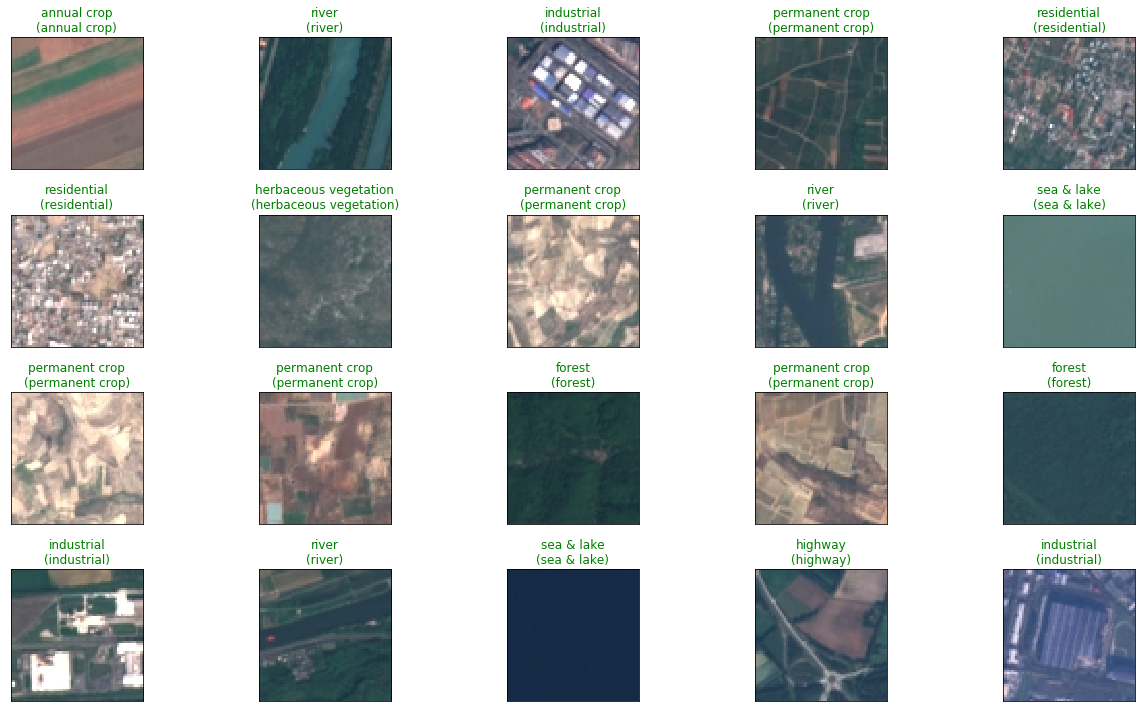

In [87]:
plot_predictions(true_classes, predictions, X_test, class_names)

## Transfer Learning
## Use VGG16 to solve our classification problem thru transfer learning.

In [92]:
from tensorflow.keras.applications.vgg16 import VGG16
def get_model_transfer_learning(input_shape, n_classes, optimizer, fine_tune=None):
    
    backbone = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape,
                     pooling='avg')
    
    x = backbone.output
    x = L.Dense(2048, activation='relu')(x)
    x = L.Dropout(0.5)(x)
    output_layer = L.Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=backbone.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in backbone.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in backbone.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

In [105]:
adam = Adam(lr = 3e-4)
model = get_model_transfer_learning(INPUT_SHAPE, NUM_CLASSES, adam, fine_tune=None)
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)     

In [106]:
from tensorflow.keras.callbacks import LearningRateScheduler
N_STEPS = len(X_train)//BATCH_SIZE
N_VAL_STEPS = len(X_valid)//BATCH_SIZE
N_EPOCHS = 2

# model callbacks
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='../cache/model_weights_best_vgg16.hdf5',
    monitor='val_categorical_accuracy',
    save_best_only=True,
    verbose=1)

early_stop2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min')

decay_steps = 100
initial_learning_rate = 3e-4
lr_decayed_fn2 = tf.keras.experimental.CosineDecay(
    initial_learning_rate, decay_steps)
lr_sched2 = LearningRateScheduler(lr_decayed_fn2)

### Train the last few layers for 2 epochs

In [107]:
train_generator.reset()
valid_generator.reset()
history = model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[lr_sched2, early_stop2, checkpoint2],
    validation_data=valid_generator,
    validation_steps=N_VAL_STEPS)

Epoch 1/2
295/295 [==============================] - ETA: 0s - loss: 1.2275 - categorical_accuracy: 0.5595
Epoch 00001: val_categorical_accuracy improved from -inf to 0.68118, saving model to ../cache/model_weights_best_vgg16.hdf5
295/295 [==============================] - 39s 131ms/step - loss: 1.2275 - categorical_accuracy: 0.5595 - val_loss: 0.9427 - val_categorical_accuracy: 0.6812
Epoch 2/2
295/295 [==============================] - ETA: 0s - loss: 0.9235 - categorical_accuracy: 0.6787
Epoch 00002: val_categorical_accuracy improved from 0.68118 to 0.72005, saving model to ../cache/model_weights_best_vgg16.hdf5
295/295 [==============================] - 39s 134ms/step - loss: 0.9235 - categorical_accuracy: 0.6787 - val_loss: 0.8130 - val_categorical_accuracy: 0.7201


In [108]:
# re-train with fine-tuning
model = get_model_transfer_learning(INPUT_SHAPE, NUM_CLASSES, adam, fine_tune=14)
model.load_weights('../cache/model_weights_best_vgg16.hdf5')

N_STEPS = len(X_train)//BATCH_SIZE
N_VAL_STEPS = len(X_valid)//BATCH_SIZE
N_EPOCHS = 100

train_generator.reset()
valid_generator.reset()



In [109]:
history = model.fit(
    train_generator,
    steps_per_epoch=N_STEPS,
    epochs=N_EPOCHS,
    callbacks=[lr_sched2, early_stop2, checkpoint2],
    validation_data=valid_generator,
    validation_steps=N_VAL_STEPS)

Epoch 1/100
295/295 [==============================] - ETA: 0s - loss: 1.9119 - categorical_accuracy: 0.2959
Epoch 00001: val_categorical_accuracy did not improve from 0.72005
295/295 [==============================] - 40s 137ms/step - loss: 1.9119 - categorical_accuracy: 0.2959 - val_loss: 1.4754 - val_categorical_accuracy: 0.4142
Epoch 2/100
295/295 [==============================] - ETA: 0s - loss: 1.3769 - categorical_accuracy: 0.4645
Epoch 00002: val_categorical_accuracy did not improve from 0.72005
295/295 [==============================] - 41s 138ms/step - loss: 1.3769 - categorical_accuracy: 0.4645 - val_loss: 1.3452 - val_categorical_accuracy: 0.4673
Epoch 3/100
295/295 [==============================] - ETA: 0s - loss: 1.2173 - categorical_accuracy: 0.5294
Epoch 00003: val_categorical_accuracy did not improve from 0.72005
295/295 [==============================] - 40s 137ms/step - loss: 1.2173 - categorical_accuracy: 0.5294 - val_loss: 1.1039 - val_categorical_accuracy: 0.567

295/295 [==============================] - 45s 153ms/step - loss: 0.2156 - categorical_accuracy: 0.9325 - val_loss: 0.2046 - val_categorical_accuracy: 0.9334
Epoch 24/100
295/295 [==============================] - ETA: 0s - loss: 0.2107 - categorical_accuracy: 0.9331
Epoch 00024: val_categorical_accuracy did not improve from 0.93341
295/295 [==============================] - 43s 146ms/step - loss: 0.2107 - categorical_accuracy: 0.9331 - val_loss: 0.2287 - val_categorical_accuracy: 0.9226
Epoch 25/100
295/295 [==============================] - ETA: 0s - loss: 0.2132 - categorical_accuracy: 0.9336
Epoch 00025: val_categorical_accuracy improved from 0.93341 to 0.93545, saving model to ../cache/model_weights_best_vgg16.hdf5
295/295 [==============================] - 45s 153ms/step - loss: 0.2132 - categorical_accuracy: 0.9336 - val_loss: 0.1986 - val_categorical_accuracy: 0.9355
Epoch 26/100
295/295 [==============================] - ETA: 0s - loss: 0.2089 - categorical_accuracy: 0.9344
Ep

Epoch 47/100
295/295 [==============================] - ETA: 0s - loss: 0.1121 - categorical_accuracy: 0.9625
Epoch 00047: val_categorical_accuracy improved from 0.95778 to 0.96019, saving model to ../cache/model_weights_best_vgg16.hdf5
295/295 [==============================] - 45s 153ms/step - loss: 0.1121 - categorical_accuracy: 0.9625 - val_loss: 0.1312 - val_categorical_accuracy: 0.9602
Epoch 48/100
295/295 [==============================] - ETA: 0s - loss: 0.1124 - categorical_accuracy: 0.9642
Epoch 00048: val_categorical_accuracy did not improve from 0.96019
295/295 [==============================] - 44s 150ms/step - loss: 0.1124 - categorical_accuracy: 0.9642 - val_loss: 0.1500 - val_categorical_accuracy: 0.9539
Epoch 49/100
295/295 [==============================] - ETA: 0s - loss: 0.1077 - categorical_accuracy: 0.9655
Epoch 00049: val_categorical_accuracy did not improve from 0.96019
295/295 [==============================] - 44s 149ms/step - loss: 0.1077 - categorical_accura

295/295 [==============================] - ETA: 0s - loss: 0.0562 - categorical_accuracy: 0.9813
Epoch 00070: val_categorical_accuracy did not improve from 0.97005
295/295 [==============================] - 44s 149ms/step - loss: 0.0562 - categorical_accuracy: 0.9813 - val_loss: 0.1233 - val_categorical_accuracy: 0.9645
Epoch 71/100
295/295 [==============================] - ETA: 0s - loss: 0.0585 - categorical_accuracy: 0.9811
Epoch 00071: val_categorical_accuracy did not improve from 0.97005
295/295 [==============================] - 45s 152ms/step - loss: 0.0585 - categorical_accuracy: 0.9811 - val_loss: 0.1216 - val_categorical_accuracy: 0.9641
Epoch 72/100
295/295 [==============================] - ETA: 0s - loss: 0.0597 - categorical_accuracy: 0.9809
Epoch 00072: val_categorical_accuracy did not improve from 0.97005
295/295 [==============================] - 45s 153ms/step - loss: 0.0597 - categorical_accuracy: 0.9809 - val_loss: 0.1070 - val_categorical_accuracy: 0.9661
Epoch 73

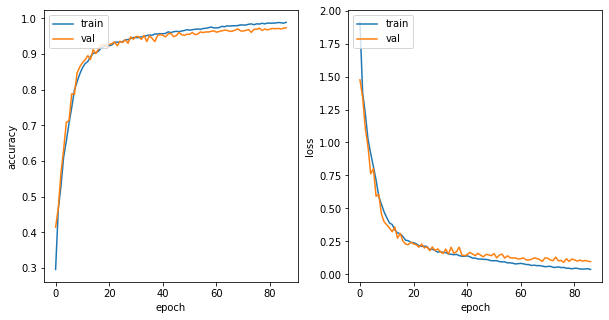

In [110]:
plot_history(history)

In [111]:
model.load_weights('../cache/model_weights_best_vgg16.hdf5')

test_generator.reset()

predictions = model.predict(test_generator)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = y_test

In [112]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true_classes, predicted_classes))

0.9640740740740741


In [113]:
prf, conf_mat = display_results(true_classes, predicted_classes, class_names)

Global F1 Score: 0.9640740740740741
Global F2 Score: 0.9640740740740741


### There is accuracy of 0.96 along with F1 and F2 scores also of 0.96 on test set. So this model generalizes quite well

In [114]:
prf

,Precision,Recall,F-Score,Support
annual crop,0.970492,0.936709,0.953301,316.0
forest,0.985915,0.996441,0.991150,281.0
herbaceous vegetation,0.967509,0.920962,0.943662,291.0
highway,0.963115,0.967078,0.965092,243.0
industrial,0.978814,0.950617,0.964509,243.0
pasture,0.975728,0.961722,0.968675,209.0
permanent crop,0.909091,0.948617,0.928433,253.0
residential,0.937695,1.000000,0.967846,301.0
river,0.954373,0.988189,0.970986,254.0
sea & lake,1.000000,0.970874,0.985222,309.0


In [115]:
conf_mat

,annual crop,forest,herbaceous vegetation,highway,industrial,pasture,permanent crop,residential,river,sea & lake
annual crop,296,1,0,2,0,1,11,0,5,0
forest,0,280,0,0,0,0,0,1,0,0
herbaceous vegetation,2,2,268,0,0,4,8,7,0,0
highway,2,0,0,235,3,0,2,0,1,0
industrial,0,0,0,0,231,0,0,12,0,0
pasture,2,0,2,1,0,201,2,0,1,0
permanent crop,1,0,6,4,2,0,240,0,0,0
residential,0,0,0,0,0,0,0,301,0,0
river,1,0,0,1,0,0,1,0,251,0
sea & lake,1,1,1,1,0,0,0,0,5,300


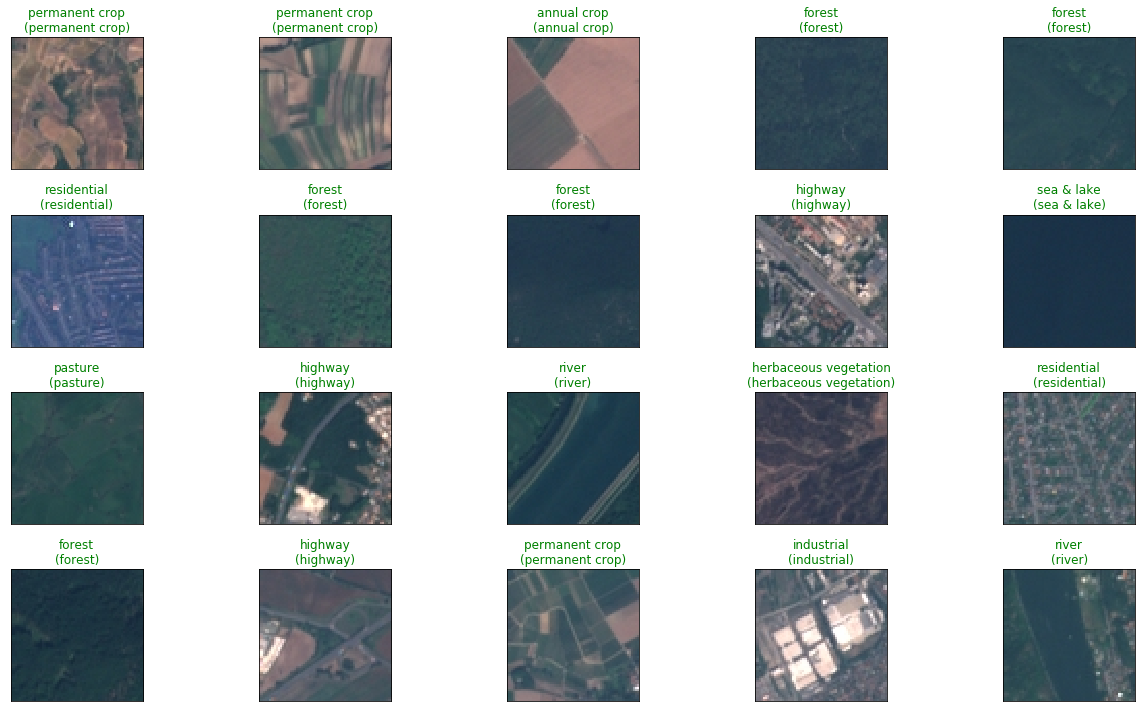

In [116]:
plot_predictions(true_classes, predictions, X_test, class_names)

# Some pointers :




> Some data visualisations of the train, validation and test data.

> Ans: This is done. See above.

> Exploratory Data Analysis of the dataset.

> Ans: This is done. See above.

> Accuracy plots

> Ans: This is done. See above.

